In [14]:
"""
Read predicted dataset, match links to given offers and send an email notification
with summary of the most interesting offers.
"""
import os
import logging as log

import pandas as pd

import columns
from common import (
    CONCATED_DATA_PATH,
    PREDICTED_DATA_PATH,
    logs_conf,
)
from s3_client import s3_client


log.basicConfig(**logs_conf)

s3_client = s3_client()

def notify_task():
    log.info("Starting notify task...")

    predicted_df_s = s3_client.read_newest_df_from_s3(PREDICTED_DATA_PATH, dtype='sale')
    concated_df_s = s3_client.read_newest_df_from_s3(CONCATED_DATA_PATH, dtype='sale')
    df_s = predicted_df_s.merge(concated_df_s[[columns.OFFER_ID, columns.URL, columns.TITLE]],
                                on=columns.OFFER_ID,
                                how='left')
    
    predicted_df_r = s3_client.read_newest_df_from_s3(PREDICTED_DATA_PATH, dtype='rent')
    concated_df_r = s3_client.read_newest_df_from_s3(CONCATED_DATA_PATH, dtype='rent')
    df_r = predicted_df_r.merge(concated_df_r[[columns.OFFER_ID, columns.URL, columns.TITLE]],
                                on=columns.OFFER_ID,
                                how='left')
    return df_s, df_r

#    notification_html = prepare_notification(predicted_df_s, concated_df_s, predicted_df_r, concated_df_r)
#    response = send_notification(notification_html)
#    if response:
#        log.info("Successfully finished notifiation task.")
#

credentials.py 18:45:16 INFO: Found credentials in shared credentials file: ~/.aws/credentials


In [15]:
df_s, df_r = notify_task() 

<ipython-input-14-94cdfc4b0488> 18:45:18 INFO: Starting notify task...
s3_client.py 18:45:19 INFO: Downloading sale/predicted/sale_predicted_2019_12_31T13_08_25.parquet from flats-data bucket ...
s3_client.py 18:45:31 INFO: Successfully downloaded sale/predicted/sale_predicted_2019_12_31T13_08_25.parquet from flats-data bucket.
s3_client.py 18:45:32 INFO: Downloading sale/concated/sale_concated_2020_01_01T00_20_17.csv from flats-data bucket ...
s3_client.py 18:49:24 INFO: Successfully downloaded sale/concated/sale_concated_2020_01_01T00_20_17.csv from flats-data bucket.
s3_client.py 18:49:31 INFO: Downloading rent/predicted/rent_predicted_2019_12_31T13_11_50.parquet from flats-data bucket ...
s3_client.py 18:49:33 INFO: Successfully downloaded rent/predicted/rent_predicted_2019_12_31T13_11_50.parquet from flats-data bucket.
s3_client.py 18:49:33 INFO: Downloading rent/concated/rent_concated_2020_01_01T00_17_41.csv from flats-data bucket ...
s3_client.py 18:50:49 INFO: Successfully down

In [16]:
df_s.head()

,balcony__offer,basement__clean,building_height__offer,building_material__offer,building_type__offer,building_year__offer,date_added__offer,date_refreshed__offer,desc_len__offer,direct__offer,...,view_count__offer,water__offer,cluster_mean_price_m2__feature,cluster_mean_price__feature,cluster_id__feature,cluster_center_dist_km__feature,cluster_coords_factor__feature,sale__prediction,url__offer,title__offer
0,1.0,1.0,3.0,3,1,2019.0,2019-12-30,2019-12-21,1768.0,0.0,...,41.0,0,192438.69,207222.222222,894,13.63,205595.095495,3373.813469,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Zabrze M., Zabrze, Centrum, SUPER LOKALIZACJA!"
1,1.0,0.0,2.0,3,1,2019.0,2019-12-30,2019-12-30,739.0,0.0,...,32.0,0,257156.42,236386.500000,1173,4.29,305740.661568,3374.245369,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Częstochowa M., Częstochowa, Raków"
2,1.0,1.0,3.0,3,1,2008.0,2019-12-30,2019-12-29,1351.0,0.0,...,62.0,0,210567.52,299000.000000,979,0.67,336580.394182,3396.194479,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Lęborski, Lębork"
3,1.0,1.0,4.0,3,2,2019.0,2019-12-30,2019-12-30,1401.0,0.0,...,12.0,0,223183.56,194800.000000,1041,0.88,341583.320493,3397.938079,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Głogowski, Głogów"
4,1.0,1.0,8.0,3,3,2019.0,2019-12-30,2019-12-30,1993.0,0.0,...,12.0,1,267886.35,308409.433333,1209,7.68,298741.720628,3402.703745,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Gliwice, Pszczyńska"


In [40]:
df_s['price_diff'] = df_s[columns.PRICE_M2] - df_s[columns.SALE_PRED]
df_s = df_s[df_s[columns.DATE_ADDED] > '2019-12-01']
df_s = df_s[df_s[columns.PRICE_M2]<20000]
top_10 = df_s.sort_values('price_diff').head(10)
top_10 = top_10[[columns.DATE_ADDED, columns.TITLE, columns.URL, columns.PRICE_M2, columns.SALE_PRED]]
top_10

,date_added__offer,title__offer,url__offer,price_m2__offer,sale__prediction
179932,2019-12-09,"Warszawa, Wola, Nowolipki, al. Solidarności",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-warszawa-wola-solidarnosci-18m2-mzn2035276953,1944.44,11620.663700
183718,2019-12-12,"Tczewski, Tczew, Nowowiejska",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-tczewski-tczew-nowowiejska-71m2-mzn2035403807,3591.04,13050.017409
183751,2019-12-12,"Tczewski, Tczew, Strzelecka",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-tczewski-tczew-strzelecka-69m2-mzn2035403806,4005.71,13050.017409
189049,2019-12-18,"Zieona Góra, Os. Zacisze",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-96m2-mzn2035414473,4334.37,12948.542593
137,2019-12-30,"Grodzisk Mazowiecki, Tadeusza Bairda",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-grodziski-grodzisk-mazowiecki-tadeusza-bairda-...,4727.47,12949.674265
181904,2019-12-10,"Stargardzki, Stargard",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-71m2-mzn2035280566,4880.77,13050.017409
182557,2019-12-11,"Dąbrowa Górnicza, Gołonóg, Piłsudskiego",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-dabrowa-gornicza-golonog-pilsudskiego-37m2-mzn...,3648.65,11768.466242
179814,2019-12-08,"Grodzisk Mazowiecki, Tadeusza Bairda",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-grodziski-grodzisk-mazowiecki-tadeusza-bairda-...,4930.47,12949.674265
164952,2019-12-03,"Grodzisk Mazowiecki, Leonida Teligi",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-grodziski-grodzisk-mazowiecki-leonida-teligi-1...,3693.57,11650.461143
1531,2019-12-23,"Kamieński, Wolin, Międzyzdroje",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-kamienski-miedzyzdroje-76m2-mzn2035421036,5250.00,13087.018808


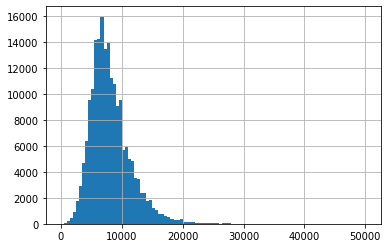

In [34]:
df_s[columns.PRICE_M2].hist(bins=100)

In [32]:
pd.options.display.max_colwidth=100 
string

159673    https://www.morizon.pl/oferta/sprzedaz-mieszkanie-kalisz-38m2-mzn2035220820
Name: url__offer, dtype: object

In [ ]:
df_r.head()